<div style="background-color: #1a41774; padding: 15px; font: bold 30px arial; color: beige; border: 2px solid red; border-radius: 8px ; text-align: center">
    Fine-tune BERT for Text Classification
</div>

## **Problem Statement**
  - fine-tune a pre-trained BERT model for text classification task. The goal is to classify the sentiment of a given text into positive or negative.

## **Dataset**
- The dataset used is the IMDB dataset, which contains 50,000 movie reviews for training and 25,000 for testing. Each review is labeled as positive or negative.
- The IMDB dataset can be found at https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz and https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz 
- The dataset is split into two parts: train and test. The train part is used for training the model, while the test part is used for evaluation.


 
 --- 

## Prepare the environment

In [ ]:
!pip install --upgrade datasets fsspec huggingface_hub


In [1]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import os



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [4]:
if torch.cuda.is_available():
    fp16_enabled = True
    print("GPU detected. Mixed precision (FP16) will be enabled.")
else:
    fp16_enabled = False
    print("No GPU detected. Mixed precision (FP16) will be disabled.")


GPU detected. Mixed precision (FP16) will be enabled.


## **Prepare the data**
 - Load the IMDB dataset from Huggingface datasets library.
 - Load the BERT tokenizer from Huggingface transformers library.
 - Tokenize the text data using the BERT tokenizer.

In [5]:
ds = load_dataset("imdb")
print('load the imbd dataset')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

load the imbd dataset


In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

ds = ds.map(tokenize, batched=True)
ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

## **Model selection**
- The choice of model depends on the research question and the type of data. For sentiment analysis, a pre-trained BERT model can be used.

In [8]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to("cuda" if torch.cuda.is_available() else "cpu") # Ensure model is on GPU if available


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### heper funcations

In [9]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


In [10]:
def plot_confusion_matrix(labels, preds, classes=["neg", "pos"]):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


## **Training the model**
 - To train the model, we need to define the loss function and the optimizer. We will use the Huggingface Trainer class to handle the training process.

In [12]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,  # Accumulate gradients over 2 batches
    eval_strategy="epoch",
    save_strategy="epoch",  # Changed save_strategy to match eval_strategy
    save_total_limit=1,
    report_to="none",
    fp16=fp16_enabled,  # Enable mixed precision training if GPU is available
    load_best_model_at_end=True, # Load the best model based on evaluation metrics at the end of training
    metric_for_best_model="accuracy" # Metric to use for selecting the best model
)

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"].shuffle(seed=42).select(range(2000)),
    eval_dataset=ds["test"].shuffle(seed=42).select(range(500)),
    compute_metrics=compute_metrics,
)

# Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.247441,0.898000
2,No log,0.286682,0.904000


TrainOutput(global_step=186, training_loss=0.24669187812394994, metrics={'train_runtime': 105.8962, 'train_samples_per_second': 56.659, 'train_steps_per_second': 1.756, 'total_flos': 778808723865600.0, 'train_loss': 0.24669187812394994, 'epoch': 2.96})

## **Evaluation and model saving** 
 

In [14]:
# Evaluate
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.25828924775123596, 'eval_accuracy': 0.906, 'eval_runtime': 1.9511, 'eval_samples_per_second': 256.261, 'eval_steps_per_second': 32.289, 'epoch': 2.96}


In [15]:
# Save model
trainer.save_model("best-bert-sentiment")

Save at google drive 

In [17]:
if not os.path.exists('/content/drive/MyDrive/text'):
    os.makedirs('/content/drive/MyDrive/text')
# Use shutil.copytree to copy the entire directory
shutil.copytree('best-bert-sentiment', '/content/drive/MyDrive/text/best-bert-sentiment', dirs_exist_ok=True)
print("Model saved to Google Drive.")

Model saved to Google Drive.


## **Prediction and his evaluation**

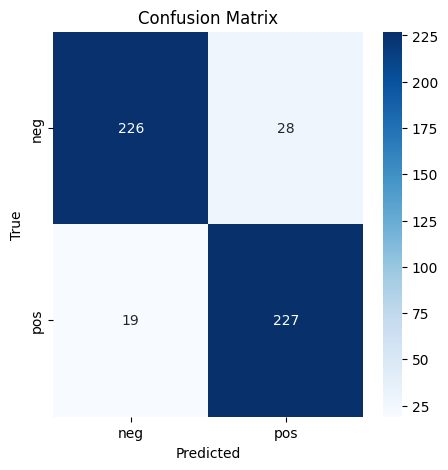

In [16]:
predictions = trainer.predict(ds["test"].shuffle(seed=42).select(range(500)))
preds = np.argmax(predictions.predictions, axis=1)
plot_confusion_matrix(predictions.label_ids, preds)


In [19]:
print("\nClassification Report:")
print(classification_report(predictions.label_ids, preds, target_names=["neg", "pos"]))


Classification Report:
              precision    recall  f1-score   support

         neg       0.92      0.89      0.91       254
         pos       0.89      0.92      0.91       246

    accuracy                           0.91       500
   macro avg       0.91      0.91      0.91       500
weighted avg       0.91      0.91      0.91       500



## **Fine-Tuned BERT Sentiment Classifier**

This project focuses on building and deploying a **sentiment classification model** using **BERT**, a powerful transformer-based language model. The model is trained on a labeled dataset of movie reviews (IMDB), then deployed using **Streamlit** to provide a real-time prediction interface.

---

### 🔁 **Project Workflow (Step-by-Step)**

| Step                                | Description                                                                                                                  |
| ----------------------------------- | ---------------------------------------------------------------------------------------------------------------------------- |
| **1. Data Loading**                 | Loaded the IMDB sentiment dataset using the Hugging Face `datasets` library.                                                 |
| **2. Text Tokenization**            | Used `bert-base-uncased` tokenizer to preprocess and tokenize text (padding, truncation).                                    |
| **3. Model Selection**              | Used Hugging Face's `AutoModelForSequenceClassification` with BERT and two output labels (positive/negative).                |
| **4. Model Fine-Tuning**            | Trained the model using Hugging Face’s `Trainer` API on GPU (or CPU). Used standard cross-entropy loss and Adam optimizer.   |
| **5. Evaluation**                   | Evaluated the model using accuracy, F1 score, and confusion matrix on the test set.                                          |
| **6. Saving Artifacts**             | Saved the model weights (`model.safetensors`), tokenizer, and config files in a local directory `bert_model/`.               |
| **7. Streamlit Integration**        | Created a simple, elegant web interface using Streamlit where users can input custom text and receive sentiment predictions. |
| **8. Deployment (Streamlit Cloud)** | Made the app publicly accessible with Streamlit Cloud for demo and real-world usage.                                         |

---

### 🛠️ **Tools & Libraries Used**

| Category          | Tool/Library                    | Purpose                                     |
| ----------------- | ------------------------------- | ------------------------------------------- |
| **NLP Framework** | Hugging Face Transformers       | Model training, tokenization, fine-tuning   |
| **Model**         | BERT (bert-base-uncased)        | Pretrained transformer-based language model |
| **Training**      | PyTorch                         | Deep learning backend                       |
| **Web App**       | Streamlit                       | Interactive deployment of ML model          |
| **Utilities**     | matplotlib, torch.nn.functional | Visualization, softmax, etc.                |
| **Storage**       | safetensors                     | Efficient model weight storage              |
| **Deployment**    | Streamlit Cloud                 | Free hosting of Streamlit applications      |

---

### 🎯 Outcome

* Achieved high accuracy in classifying sentiment with minimal fine-tuning.
* Deployed a fully functional, user-friendly app that classifies custom user input.
* Gained practical experience in bridging ML research with real-world application.


#


 ---
<div style="background-color: #1a41774; padding: 15px; font: bold 30px arial; color: beige; border: 2px solid red; border-radius: 8px ; text-align: center">
  <p style="text-align: center;">Thank you for your time and efforts!</p>
  <h3 style="text-align: center;">By: Youssef Bassiony Abdlah</h3>
  <div style="display: inline-block; text-algeint: center">
    <a  href="youssefbassiony113@gmail.com" title="Redirect to e-mail">
      <img src="https://img.icons8.com/?size=100&id=37246&format=png&color=000000"  alt="e-mail" style="width: 50px; height: 50px; margin: 0 10px; ">
    </a>
    <a href="https://wa.me/+201001725166/" title="Redirect to What'sApp">
      <img src="https://img.icons8.com/?size=160&id=A1JUR9NRH7sC&format=png" alt="What'sApp" style="width: 50px; height: 50px; margin: 0 10px;">
    </a>
    <a href="https://www.linkedin.com/in/youssef-bassiony/" title="Redirect to LinkedIn">
      <img src="https://img.icons8.com/?size=100&id=xuvGCOXi8Wyg&format=png&color=000000" alt="LinkedIn" style="width: 50px; height: 50px; margin: 0 10px;">
    </a>
  </div>
</div>
